In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt
# import albumentations as A
import cv2 as cv
import io
import wandb
import os
import tensorflow_model_optimization as tfmot

In [10]:
#### instead of import like the listed belove [from tensorflow.keras.* import *]
#### using directly  tf.keras.layers.*, tf.keras.Sequential


## DO NOT DO THIS

# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
#                                      Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
#                                      Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
#                                      RandomContrast, Rescaling, Resizing, Reshape)
# from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
# from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
#                                         ModelCheckpoint, ReduceLROnPlateau)
# from tensorflow.keras.regularizers  import L2, L1
# from tensorflow.train import BytesList, FloatList, Int64List
# from tensorflow.train import Example, Features, Feature

from sklearn.metrics import confusion_matrix, roc_curve
from tensorboard.plugins.hparams import api as hp
from wandb.integration.keras import WandbCallback, WandbMetricsLogger

# Data preparation

## Dataconfiguration

In [1]:
train_directory = 'C:/Users/Admin/Desktop/Tensor_2/dataset/Emotions Dataset/Emotions Dataset/train'
val_directory = 'C:/Users/Admin/Desktop/Tensor_2/dataset/Emotions Dataset/Emotions Dataset/test'
CLASS_NAMES = ["angry", "happy", "sad"]
CONFIGURATION = {
    "BATCH_SIZE":16,
    "IM_SIZE": 256,
    "LEARNING_RATE":0.001,
    "N_EPOCHS": 2,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 64,
    "N_DENSE_2": 32,
    "NUM_CLASSES" :3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 192,
}
# wandb.Config = CONFIGURATION

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels = "inferred",
    label_mode = "categorical",
    class_names = CLASS_NAMES,
    color_mode = "rgb",
    batch_size = CONFIGURATION["BATCH_SIZE"],
    image_size = (CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle = True,
    seed = 99
    # validation_split = 0.2,
    # subset = "training",
)

Found 6799 files belonging to 3 classes.


In [8]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels = "inferred",
    label_mode = "categorical",
    class_names = CLASS_NAMES,
    color_mode = "rgb",
    batch_size = 1,
    image_size = (CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle = True,
    seed = 99
    # validation_split = 0.2,
    # subset = "training",
)

Found 2278 files belonging to 3 classes.


## Data Augmentation

In [9]:
augment_layers = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor = (-0.025, 0.025)),
    tf.keras.layers.RandomFlip(mode = 'horizontal'),
    tf.keras.layers.RandomContrast(factor = 0.1)
])

@tf.function
def augment_layer(image, label):
    return augment_layers(image,training =True), label

### Cutmix

In [ ]:
IM_SIZE = CONFIGURATION['IM_SIZE']
@tf.function
def box(lamda):
    r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE ).sample(1)[0], dtype= tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE ).sample(1)[0], dtype= tf.int32)

    r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
    r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

    r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
    r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

    x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
    y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

    r_w = x_b_r - r_x
    if(r_w == 0):
        r_w = 1
    r_h = y_b_r - r_y
    if(r_h ==0):
        r_h = 1
    return r_y, r_x, r_h, r_w

In [ ]:
@tf.function
def cutmixup(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]
  
  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [ ]:
train_dataset_1 =  (
    train_dataset.map(augment_layer, num_parallel_calls= tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
)
train_dataset_2 =  (
    train_dataset.map(augment_layer, num_parallel_calls= tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
)

mixed_dataset = tf.data.Dataset.zip(train_dataset_1,train_dataset_2)

## Data pipelining

In [ ]:
# training_dataset = (
#     mixed_dataset
#     .map(cutmixup, num_parallel_calls= tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )
# validation_dataset = (
#     val_dataset
#     .prefetch(tf.data.AUTOTUNE)
# )

In [10]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls= tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

## TFRecords

### Convert tf.data.Dataset to TFRecords

In [99]:
training_dataset = (
    training_dataset
    .unbatch()
    # .prefetch(tf.data.AUTOTUNE)
)
# validation_dataset = (
#     val_dataset
#     .unbatch()
# )

In [9]:
def create_example(image, label):
    
    bytes_feature = Feature(
        bytes_list=BytesList(value=[image]))

    int_feature = Feature(
        int64_list=Int64List(value=[label]))

    example = Example(
        features=Features(feature={
            'images': bytes_feature,
            'labels': int_feature,
        }))
  
    return example.SerializeToString()

In [10]:
NUM_SHARDS = 10
PATH = 'shard_{:02d}.tfrecord'

In [ ]:
image = next(iter(training_dataset.take(1)))[0].numpy()

# image = tf.image.convert_image_dtype(image,tf.uint8)
# print(tf.image.convert_image_dtype(image,tf.uint8))
print(tf.image.convert_image_dtype(image/255,tf.uint8))
# # print(image)

In [82]:
def encode_image(image, label):
    image = tf.image.convert_image_dtype(image/255,dtype = tf.uint8,saturate=True)
    image = tf.io.encode_jpeg(image)
    return image,tf.argmax(label)

encoded_dataset = (
    training_dataset
    .map(encode_image)
)

In [83]:
for shard_number in range(NUM_SHARDS):
    sharded_dataset = (
        encoded_dataset
        .shard(NUM_SHARDS, shard_number)
        .as_numpy_iterator()
    )
    with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
        for encoded_image, encoded_label in sharded_dataset:
      
            example = create_example(encoded_image, encoded_label)
            file_writer.write(example)
       

### Convert TFRecords to tf.data.Dataset

In [78]:
recons_dataset = tf.data.TFRecordDataset(filenames=[PATH.format(p) for p in range(NUM_SHARDS-2)])

In [79]:
def parse_tfrecords(example):
  
    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }
    
    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]

In [84]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

In [108]:
parsed_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Data visualization

In [ ]:
plt.figure(figsize=(12,12))

for images, labels in training_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255)
        plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()])
        plt.axis("off")
    

# Modeling and Training

## Modeling

In [4]:
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    tf.keras.layers.Rescaling(1./255)
])

In [ ]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']
N_DENSE_1 = CONFIGURATION['N_DENSE_1']
N_DENSE_2 = CONFIGURATION['N_DENSE_2']
NUM_CLASSES = CONFIGURATION['NUM_CLASSES']

lenet_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = (None,None,3)),

    resize_rescale_layers,

    tf.keras.layers.Conv2D(filters = N_FILTERS, kernel_size=KERNEL_SIZE,
        strides=N_STRIDES, padding="valid",activation ='relu',
        kernel_regularizer=tf.keras.regularizers.L2(REGULARIZATION_RATE)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=POOL_SIZE,strides=N_STRIDES*2),
    tf.keras.layers.Dropout(rate = DROPOUT_RATE),

    tf.keras.layers.Conv2D(filters = N_FILTERS*2+ 4, kernel_size=KERNEL_SIZE,
        strides=N_STRIDES, padding="valid",activation ='relu',
        kernel_regularizer=tf.keras.regularizers.L2(REGULARIZATION_RATE)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=POOL_SIZE,strides=N_STRIDES*2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(N_DENSE_1, activation ="relu", kernel_regularizer=tf.keras.regularizers.L2(REGULARIZATION_RATE)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate = DROPOUT_RATE),

    tf.keras.layers.Dense(N_DENSE_2, activation ="relu", kernel_regularizer=tf.keras.regularizers.L2(REGULARIZATION_RATE)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(NUM_CLASSES, activation ="softmax")])
lenet_model.summary()

## Training

In [11]:
# loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
loss_function = tf.keras.losses.CategoricalCrossentropy()

In [12]:
# metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
metrics = [tf.keras.metrics.CategoricalAccuracy(name = 'accuracy'), tf.keras.metrics.TopKCategoricalAccuracy(k=2,name = 'top_k_accuracy')]

In [ ]:
lenet_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate= CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 10,
    verbose = 1
)

### Visualize trianing

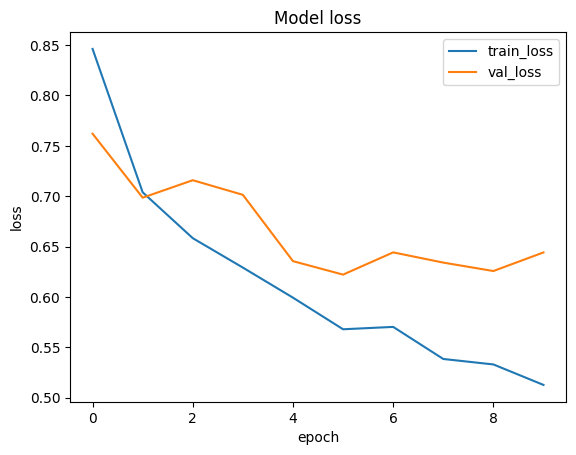

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

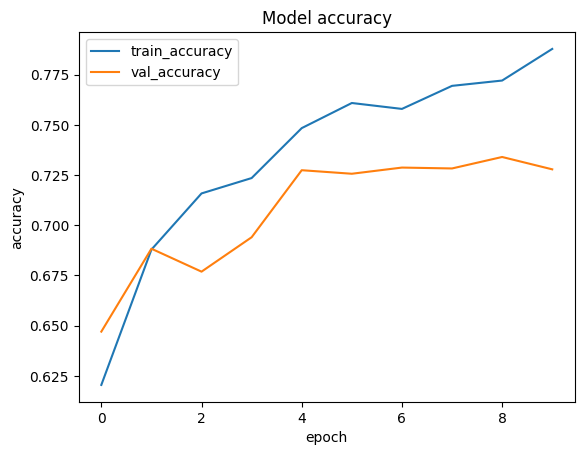

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Evaluation

In [20]:
lenet_model.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - accuracy: 0.7176 - loss: 0.6591 - top_k_accuracy: 0.9195


[0.6442417502403259, 0.7278314232826233, 0.9170324802398682]

# Testing

In [21]:
test_image = cv.imread("C:/Users/Admin/Desktop/Tensor_2/dataset/Emotions Dataset/Emotions Dataset/test/happy/52873.jpg_brightness_2.jpg")
test_image = cv.resize(test_image, (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
im = tf.constant(test_image, dtype = tf.float32)

print(im.shape)

im = tf.expand_dims(im, axis = 0)

print(CLASS_NAMES[tf.argmax(lenet_model(im),axis = -1).numpy()[0]])

(256, 256, 3)


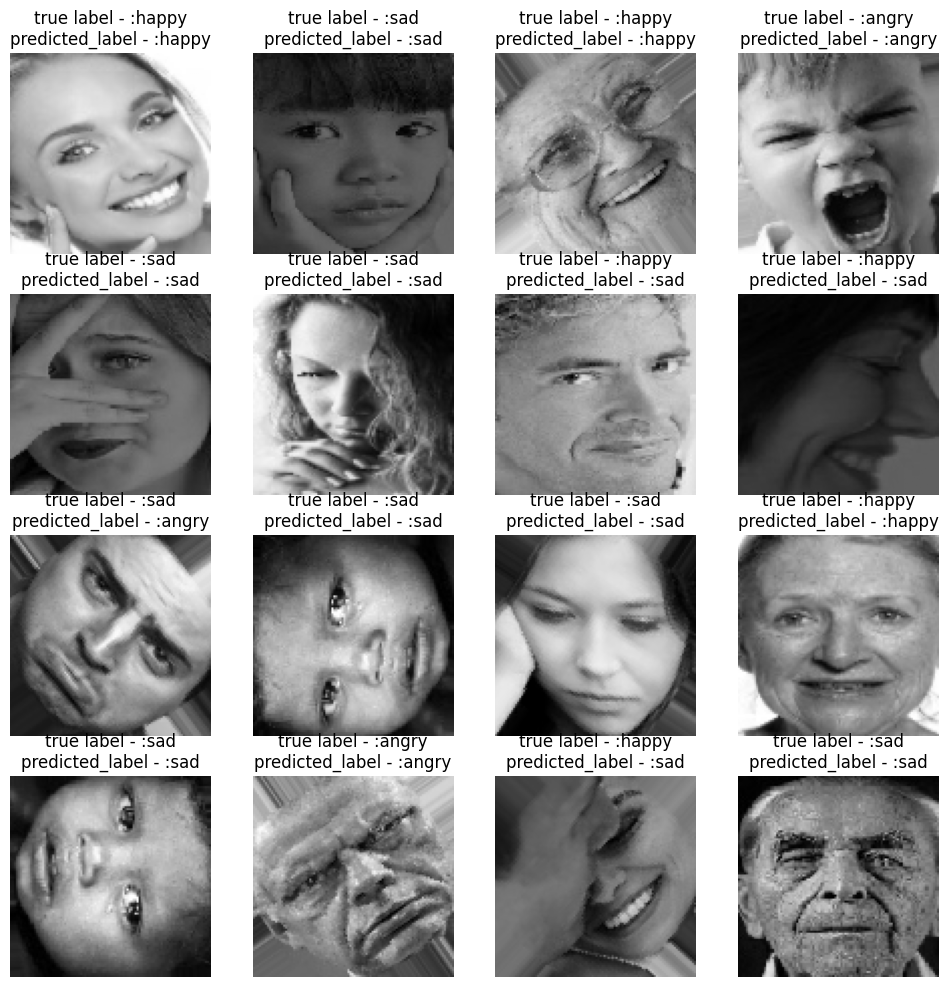

In [24]:
plt.figure(figsize=(12,12))

for images, labels in validation_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255)
        plt.title(
        "true label - :" + CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()]+'\n'+ "predicted_label - :" + CLASS_NAMES[tf.argmax(lenet_model(tf.expand_dims(images[i],axis = 0)),axis = -1).numpy()[0]])
        plt.axis("off")

# Visualization Hidden Layer output

In [10]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3),
)

In [ ]:
vgg_backbone.summary()

In [43]:
def is_conv(name):
    if 'conv' in name:
        return True
    else:
        return False

In [ ]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name) == True ]
print(feature_maps[12])
feature_maps_model = tf.keras.Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps  
)
feature_maps_model.summary()

In [46]:
f_maps = feature_maps_model.predict(im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


In [52]:
print(len(f_maps))

13


In [48]:
for i in range(len(f_maps)):
    print(f_maps[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


In [ ]:
for i in range(len(f_maps)):
    plt.figure(figsize = (256,256))
    f_size = f_maps[i].shape[1]
    n_channels = f_maps[i].shape[3]
    joint_maps = np.ones((f_size,f_size*n_channels))
    
    print(joint_maps.shape)

    axs = plt.subplot(len(f_maps),1, i+1)
    for j in range(n_channels):
        joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][...,j]
    plt.imshow(joint_maps[:,0:512])
    plt.axis("off")

# GradCAM

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

In [ ]:
x = backbone.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = tf.keras.layers.Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

gradcam_model = tf.keras.Model(backbone.inputs, output) 
gradcam_model.summary()

In [14]:
last_conv_layer_name = "top_activation"
last_conv_layer = gradcam_model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(gradcam_model.inputs, last_conv_layer.output)

In [ ]:
last_conv_layer_model.summary()

In [16]:
classifier_layer_names = [
 "global_average_pooling2d",
 "dense",
 "dense_1",
 "dense_2"
]

In [17]:
classifier_input = tf.keras.layers.Input(shape=(8,8,2048))
x = classifier_input 
for layer_name in classifier_layer_names:
 x = gradcam_model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [27]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(im)
  print(last_conv_layer_output.shape)
  preds = classifier_model(last_conv_layer_output)
  print(preds)
  top_pred_index = tf.argmax(preds[0])
  print(top_pred_index)
  top_class_channel = preds[:, top_pred_index]
  print(top_class_channel)

grads = tape.gradient(top_class_channel, last_conv_layer_output)

(1, 8, 8, 2048)
tf.Tensor([[0.3401619 0.3329181 0.32692  ]], shape=(1, 3), dtype=float32)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([0.3401619], shape=(1,), dtype=float32)


In [24]:
grads.shape

TensorShape([1, 8, 8, 2048])

In [25]:
pooled_grads = tf.reduce_mean(grads, axis = (0,1,2)).numpy()

In [16]:
print(pooled_grads.shape)

(2048,)


In [28]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [29]:
print(last_conv_layer_output.shape)

(8, 8, 2048)


In [37]:
heatmap = np.sum(last_conv_layer_output, axis=-1)
print(heatmap.shape)

(8, 8)


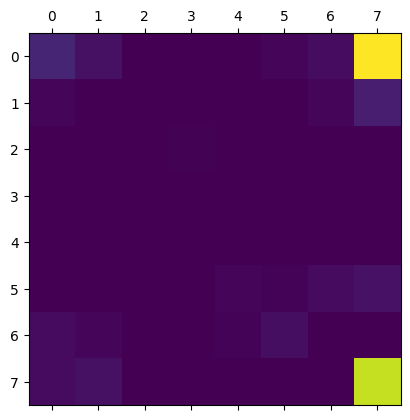

In [31]:
heatmap=tf.nn.relu(heatmap)
plt.matshow(heatmap)

In [ ]:
resized_heatmap=cv.resize(np.array(heatmap),(256,256))
plt.matshow(resized_heatmap*100+im[0,:,:,0]/255)
# plt.matshow(resized_heatmap*100+im[0,:,:,1]/255)
# plt.matshow(resized_heatmap*100+im[0,:,:,2]/255)

# Confusion Matrix

In [26]:
predicted = []
labels = []
for im, label in validation_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())

In [ ]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(),np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(),np.argmax(predicted[-1], axis = -1).flatten()]))


In [27]:
pred = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(),np.argmax(labels[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(),np.argmax(predicted[-1], axis = -1).flatten()])


[[205  27  23]
 [ 86 804  85]
 [224 175 649]]


<Axes: >

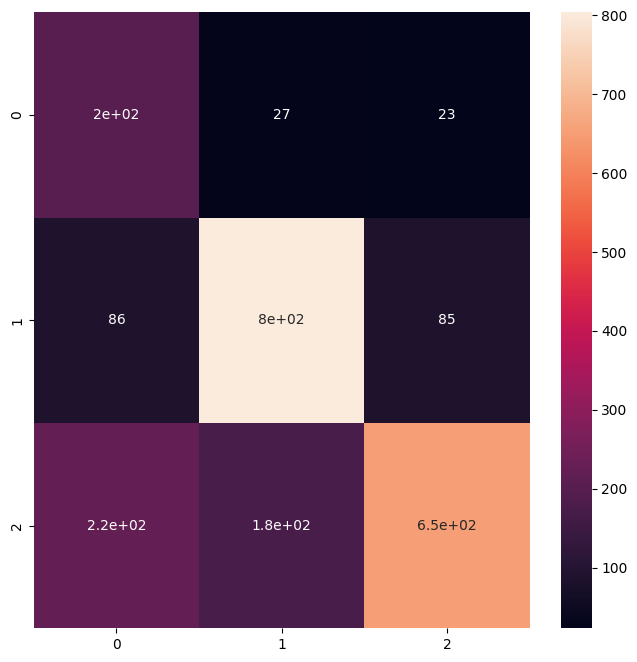

In [28]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot = True)

# Transfer Learning

## Transfer learning with EfficientNet

In [14]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

In [15]:
backbone.trainable = False   # prevent weight of backbon from updating

In [ ]:
pretrained_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    tf.keras.layers.Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),
    
    ])
pretrained_model.summary()

In [17]:
loss_function = tf.keras.losses.CategoricalCrossentropy()

In [18]:
metrics = [tf.keras.metrics.CategoricalAccuracy(name = 'accuracy'), tf.keras.metrics.TopKCategoricalAccuracy(k=2,name = 'top_k_accuracy')]

In [ ]:
checkpoint_callback =tf.keras.callbacks.ModelCheckpoint(
    'best_weights',
    monitor= 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True
)

### FineTunning EfficientNet

In [72]:
backbone.trainable = True

In [68]:
### Before fintunning do transfer training first
### by set backbone.trainable = Fasle
### after training is done set backbone.trainable = True then apply finetunning

input = tf.keras.layers.Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),

x = backbone(input, training =  False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = tf.keras.layers.Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)
    
finetuned_model = tf.keras.Model(input,output)

### TRAIN

In [75]:
finetuned_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate= CONFIGURATION['LEARNING_RATE']/10),
    loss = loss_function,
    metrics = metrics
)

In [76]:
history = finetuned_model.fit(
    training_dataset.take(10),
    validation_data = validation_dataset,
    epochs = 2,
    verbose = 1
)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.6088 - loss: 1.1867 - top_k_accuracy: 0.8553 - val_accuracy: 0.6097 - val_loss: 0.8449 - val_top_k_accuracy: 0.8573
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5966 - loss: 0.9230 - top_k_accuracy: 0.8790 - val_accuracy: 0.6097 - val_loss: 0.8592 - val_top_k_accuracy: 0.8468


In [48]:
pretrained_model.save_weights('pretrained.weights.h5')

# Transformer

In [122]:
test_image = cv.imread("C:/Users/Admin/Desktop/Tensor_2/dataset/Emotions Dataset/Emotions Dataset/test/happy/38084.jpg_rotation_1.jpg")
test_image = cv.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
     

patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis = 0),
                           sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
     

print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


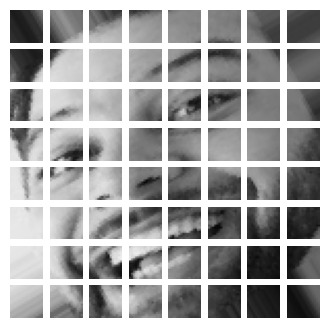

In [75]:
plt.figure(figsize = (4,4))

for i in range(patches.shape[1]):

    ax = plt.subplot(8,8, i+1)
    plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
    plt.axis("off")

### Custom input embedding

In [21]:
class PatchEnconder(tf.keras.layers.Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE, padding = 'valid'):
    super(PatchEnconder, self).__init__(name = 'patch_econder')

    self.linear_projection = tf.keras.layers.Dense( HIDDEN_SIZE)
    self.positional_embedding = tf.keras.layers.Embedding(N_PATCHES, HIDDEN_SIZE)
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(images=x,
                           sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
    
    patches = tf.reshape(patches, (CONFIGURATION['BATCH_SIZE'], 256, patches.shape[-1]))
    embedding_input = tf.range(start = 0 , limit = self.N_PATCHES,delta = 1 )
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)
    

    return output

In [ ]:
patch_enc = PatchEnconder(64,768)
patch_enc(tf.zeros([32,256,256,3]))

In [19]:
class TransformerEnconder(tf.keras.layers.Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEnconder, self).__init__(name = 'transformer_econder')

    self.layer_norm_1 = tf.keras.layers.LayerNormalization()
    self.layer_norm_2 = tf.keras.layers.LayerNormalization()
    self.multi_head_attention = tf.keras.layers.MultiHeadAttention(N_HEADS, HIDDEN_SIZE)

    self.dense_1 = tf.keras.layers.Dense(HIDDEN_SIZE, activation= tf.nn.gelu)
    self.dense_2 = tf.keras.layers.Dense(HIDDEN_SIZE, activation= tf.nn.gelu)

  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_attention(x_1,x_1)
    
    x_1 = tf.keras.layers.Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)    
    output =  tf.keras.layers.Add()([output,x_1])

    return output

In [102]:
trans_enc = TransformerEnconder(8,768)
trans_enc(tf.zeros([1,256,768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [22]:
class ViT(tf.keras.Model):
    def __init__(self, N_HEADS, HIDDEN_SIZE,N_PATCHES,N_LAYERS, N_DENSE_UNITS):
        super(ViT,self).__init__(name= 'vision_transformer')
        
        self.N_LAYERS = N_LAYERS
        self.patch_encoder = PatchEnconder(N_PATCHES,HIDDEN_SIZE)
        self.trans_encoders = [ TransformerEnconder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
        self.dense_1 = tf.keras.layers.Dense(N_DENSE_UNITS, tf.nn.gelu)
        self.dense_2 = tf.keras.layers.Dense(N_DENSE_UNITS, tf.nn.gelu)
        self.dense_3 = tf.keras.layers.Dense(CONFIGURATION['NUM_CLASSES'], activation= 'softmax')

    def call(self, input, training= True):
        
        x = self.patch_encoder(input)

        for i in range(self.N_LAYERS):
            x = self.trans_encoders[i](x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_1(x)
        x = self.dense_2(x)

        return self.dense_3(x)


In [ ]:
vit = ViT(4, 768, 256, 2, 128)
vit(tf.zeros([2,256,256,3]))

In [ ]:
vit.summary()

In [118]:
vit.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [121]:
vit.load_weights('vit.h5')

In [ ]:
test_dataset = validation_dataset.take(1)
dataset = tfds.as_numpy(test_dataset)
labels=[]
for x in true_label:
   labels = tf.argmax(x[1], axis = 1)

labels = [CLASS_NAMES[x] for x in labels]
predict = vit.predict(test_dataset)
result = tf.argmax(predict, axis =1 )
for i in result:
    print(CLASS_NAMES[i], labels[i])

In [ ]:
history = vit.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 1,
    verbose = 1
    
)

### FineTuning Huggingface ViT

#### Installation

In [10]:
from transformers import TFViTModel, ViTConfig

In [11]:
# Initializing a ViT vit-base-patch16-224-style configuration
configuration = ViTConfig()

# Initializing a model from the vit-base-patch16-224 style configuration
model = TFViTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [ ]:
print(configuration)

In [14]:
resize_rescale_hf = tf.keras.Sequential([
    tf.keras.layers.Resizing(224,224),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Permute((3,1,2))
])

In [15]:
base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

class HFModel(tf.keras.Model):
    def __init__(self):
        super(HFModel,self).__init__()

        self.resize_rescale_hf = resize_rescale_hf
        self.base_model = base_model
        self.output_layer = tf.keras.layers.Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

    def call(self, x):
        x = self.resize_rescale_hf(x)
        x = self.base_model.vit(x)[0][:,0,:]
        x = self.output_layer(x)
       
        return x
        
hf_model = HFModel()
hf_model(tf.random.normal(
    [1,256,256,3],
    mean=0.0,
    stddev=0.5,
    dtype=tf.dtypes.float32,
))
     

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.3714054 , 0.37558925, 0.25300536]], dtype=float32)>

In [19]:
hf_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss = loss_function,
    metrics = metrics,
)

In [ ]:
class LogConfMatrix(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        predicted = []
        labels = []
        for im, label in validation_dataset:
            predicted.append(hf_model(im))
            labels.append(label.numpy())
        pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1],axis = -1).flatten()])
        lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1],axis = -1).flatten()])
        cm = wandb.plot.confusion_matrix(
            y_true = lab,
            preds = pred,
            class_names = ['angry','happy','sad']
        )
        wandb.log({"conf_mat":cm})

In [ ]:
class LogResultTable(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    columns = ["image","Predicted", "Label"]

    val_table = wandb.Table(columns=columns)

    for im, label in validation_dataset.take(25):
      pred = CONFIGURATION["CLASS_NAMES"][tf.argmax(hf_model(im),axis = -1).numpy()[0]]
      label = CONFIGURATION["CLASS_NAMES"][tf.argmax(label,axis = -1).numpy()[0]]

      row += [wandb.Image(im), pred, label]

      val_table.add_data(*row)
    wandb.log({"Model results":val_table})

In [24]:
history = hf_model.fit(
    training_dataset.take(20),
    validation_data = validation_dataset.take(10),
    epochs = 1,
    verbose = 1,
    # callbacks = [WandbMetricsLogger(), LogConfMatrix()]
)

20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.3513 - loss: 1.1148 - top_k_accuracy: 0.6762 - val_accuracy: 0.4000 - val_loss: 1.0313 - val_top_k_accuracy: 0.8000


In [25]:
hf_model.evaluate(validation_dataset.take(10))

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.6267 - loss: 0.9684 - top_k_accuracy: 0.8744


[1.0281566381454468, 0.5, 0.699999988079071]

# MODEL DEPLOYMENT

## Exporting to ONNX format

In [31]:
# hf_model.save('vit_finetuned.keras')

In [ ]:
# !pip install tf2onnx
# !pip install onnxruntime

In [ ]:
# !python -m tf2onnx.convert --saved-model mobilenet/ --output model.onnx

In [ ]:
# import tf2onnx
# import onnxruntime as rt
# from onnxruntime.quantization import quantize_dynamic, QuantType

In [ ]:
# THIS CELL IS ONLY USE ONCE WHEN YOU FIRST TRAIN THE TFMODEL AND CONVERT IT TO ONNX MODEL 

# spec = (tf.TensorSpec(
#     (None, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3),
#     tf.float32, name= "input"
# ),)

# output_path = "vit_keras.onnx"

# model_proto, _ = tf2onnx.convert.from_keras(hf_model, input_signature = spec, opset = 13, output_path= output_path)
# output_names = [ n.name for n in model_proto.graph.output ]

In [ ]:
# THIS CELL IS WHEN YOU WANT TO QUANTIZE YOUR ONNX MODEL TO QUANTIZED ONNX MODEL

# model_fp32 = 'C:\Users\Admin\Desktop\Tensor_2\vit_keras_1.onnx'
# model_quant = 'C:\Users\Admin\Desktop\Tensor_2\vit_quantized.onnx'

# quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type= QuantType.QUInt8)

In [ ]:
# providers = ['CPUExecutionProvider', 'CUDAExecutionProvider']
# m = rt.InferenceSession(output_path, providers = providers)      #! output path is the path to the onnx model file

# onnx_pred = m.run(output_names, {"input": im})            #! output name is the list of name of the outputs of onnx model ->['output_1']

In [ ]:
# tf_model_size = 1000MB
# tf_model_CPU  = 0.8s
# tf_model_GPU  = 0.15s


# ONNX_model_size = 328MB
# ONNX_model_CPU  = 0.5s
# ONNX_model_GPU  = 0.025s

# ONNX_quantized_model_size = 83MB
# ONNX_quantized_model_CPU  = 0.4s
# ONNX_quantized_model_GPU  = 0.3s

In [ ]:
# print(onnx_pred)

## Quantization Aware Training (QAT)

In [ ]:
backbone,
x = tf.keras.layers.GlobalAveragePooling2D()(backbone.output)
x = tf.keras.layers.Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = tf.keras.layers.Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_func_model = tf.keras.Model(inputs = backbone.input, outputs = output)

pretrained_func_model.summary()

In [30]:
def apply_quantization_to_conv(layer):
  if "conv" in layer.name:
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

In [31]:
quant_aware_eff = tf.keras.models.clone_model(
    pretrained_func_model, clone_function=apply_quantization_to_conv
)

In [ ]:
quant_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_eff)
quant_aware_model.summary()

In [33]:
quant_aware_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-4),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history= quant_aware_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 1,
    verbose = 1
)

## Post Training Quantization

In [19]:
pretrained_model.load_weights('eff_net.h5')

In [26]:
pretrained_model.evaluate(validation_dataset.take(100))

100/100 [==============================] - 49s 489ms/step - loss: 0.7516 - accuracy: 0.6900 - top_k_accuracy: 0.9100


[0.7515985369682312, 0.6899999976158142, 0.9100000262260437]

In [1]:
# gen representative data for static quantization

def representative_data_gen():
    for input_value, j in training_dataset.take(2):
        yield[input_value]

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(pretrained_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_data_gen # When you don't define this by default the quantization mode = Dynamic quantization
                                                           # And when it is dynamic only tf.float32 allowed for inference_input/output_type

In [33]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp4zau7nt9\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp4zau7nt9\assets
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [35]:
import pathlib

tflite_models_dir = pathlib.Path("C:/Users/Admin/Desktop/Tensor_2/lite_quantized_models/")  
tflite_models_dir.mkdir(exist_ok= True, parents=True)

tflite_model_file = tflite_models_dir/'eff_model.tflite'
tflite_model_file.write_bytes(tflite_model)

20263848

In [ ]:
import tflite_runtime.interpreter as tflite  # use this command when tensorflow wasn't import
# import tflite_runtime as tflite  # use this command when tensorflow was imported

In [ ]:
test_image = cv.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg")
test_image = cv.resize(test_image, (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))

im = np.expand_dims(test_image, axis=0)

In [ ]:
interpreter = tf.lite.Interpreter(model_path='C:/Users/Admin/Desktop/Tensor_2/lite_quantized_models/eff_model.tflite') # when tensorflow was imported use tf.lite.Interpreter
interpreter.allocate_tensors()                                                                                # when tensorflow wasn't imported use tflite.Interpreter

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_ouptut_details()[0]

interpreter.set_tensor(input_details['index'],test_image)
interpreter.invoke()

output = interpreter.get_tensor(output_details["index"])[0]
print(CONFIGURATION['CLASS_NAMES'][np.argmax(output)])